In [5]:
import gzip
import pandas as pd
from datetime import time
import matplotlib.pyplot as plt
import itertools
import math
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import time as time_module
from tqdm.notebook import tqdm
import warnings
from talipp.ohlcv import OHLCV
from talipp.indicators import AccuDist, ADX, ALMA, AO, Aroon, ATR, BB, BOP, CCI, ChaikinOsc, ChandeKrollStop, CHOP, \
    CoppockCurve, DEMA, DonchianChannels, DPO, EMA, EMV, ForceIndex, HMA, Ichimoku, KAMA, KeltnerChannels, KST, KVO, \
    MACD, MassIndex, MeanDev, OBV, PivotsHL, ROC, RSI, ParabolicSAR, SFX, SMA, SMMA, SOBV, StdDev, Stoch, StochRSI, \
    SuperTrend, TEMA, TRIX, TSI, TTM, UO, VTX, VWAP, VWMA, WMA

# Ignore FutureWarning messages
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
def load_dataframe_from_gz(gz_file_path):
    with gzip.open(gz_file_path, "rt") as file:
        df = pd.read_csv(file)
    return df

deep_path = "data/20211105_book_updates.csv.gz"
df_deep = load_dataframe_from_gz(deep_path)

In [112]:
def filter_stock(df, stock_tickers):
    filtered_data = df[df["SYMBOL"].isin(stock_tickers)]
    return filtered_data

def generate_indicators(df_original, list_indicator = ["MACD", "BOP", "RSI", "SOBV"]):
    df = df_original.copy()

    close = [float(row['CLOSE']) for index, row in df.iterrows()]
    ohlcv = [OHLCV(float(row['OPEN']), float(row['HIGH']), float(row['LOW']), float(row['CLOSE']), float(row['VOLUME']))
                for _, row in df.iterrows()]

    # Define the indicators
    bop = BOP(ohlcv)
    sobv = SOBV(7, ohlcv)
    stoch = Stoch(14, 3, ohlcv)
    force_index = ForceIndex(13, ohlcv)
    macd = MACD(12, 26, 9, close)
    rsi = RSI(14, close)
    atr = ATR(14, ohlcv)
    cci = CCI(20, ohlcv)
    vwap = VWAP(ohlcv)
    sar = ParabolicSAR(0.02, 0.02, 0.2, ohlcv)
    indicators_dict = {
        "BOP": bop,
        "SOBV": sobv,
        "STOCH": [stoch_k.k for stoch_k in stoch],
        "FORCE_INDEX": force_index,
        "MACD": [macd_hist.histogram for macd_hist in macd],
        "RSI": rsi,
        "ATR": atr,
        "CCI": cci,
        "VWAP": vwap,
        "SAR": [sar_val.value for sar_val in sar],
    }

    # Add the indicators to the DataFrame
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        for key in list_indicator:
            df[key], value = np.nan, indicators_dict[key]
            start_index = len(df) - len(value)
            df[key][start_index:] = value

    return df

In [113]:
stock_list = ["AAPL"]
df_aapl = filter_stock(df_deep, stock_tickers=stock_list)
df_aapl['COLLECTION_TIME'] = pd.to_datetime(df_aapl['COLLECTION_TIME'])
df_aapl.set_index('COLLECTION_TIME', inplace=True)
df_aapl["MID_PRICE"] = (df_aapl["BID_PRICE_1"] + df_aapl["ASK_PRICE_1"]) / 2
df_aapl["VOLUME"] = df_aapl["BID_SIZE_1"] + df_aapl["ASK_SIZE_1"]
df_price_volume = df_aapl[["MID_PRICE", "VOLUME"]].copy()

In [114]:
df_ohlcv = df_price_volume.resample('5s').agg({
    'MID_PRICE': ['first', 'last', 'max', 'min'],
    'VOLUME': 'sum',
    
})

df_ohlcv.columns = ['OPEN', 'CLOSE', 'HIGH', 'LOW', 'VOLUME']
df_ohlcv.dropna(inplace=True)

df_data = generate_indicators(df_ohlcv)
df_data.dropna(inplace=True)

In [115]:
df_ohlcv

OPEN    CLOSE     HIGH      LOW  VOLUME
COLLECTION_TIME                                                
2021-11-05 13:30:00  150.740  150.740  152.880  149.745  203878
2021-11-05 13:30:05  152.815  150.390  152.830  149.705   84570
2021-11-05 13:30:10  152.165  150.130  152.270  149.755  144318
2021-11-05 13:30:15  149.710  152.160  152.215  149.710   22213
2021-11-05 13:30:20  150.130  150.130  152.180  149.655   50799
...                      ...      ...      ...      ...     ...
2021-11-05 19:59:40  151.245  151.355  151.370  150.615   40698
2021-11-05 19:59:45  151.355  151.430  151.430  150.620   49801
2021-11-05 19:59:50  151.430  150.965  151.630  150.765    8048
2021-11-05 19:59:55  151.635  151.265  151.930  150.965    3231
2021-11-05 20:00:00  151.265  151.265  151.265  151.265     372

[4669 rows x 5 columns]

In [116]:
df_data["target"] = (df_data['CLOSE'].shift(-1) > df_data['CLOSE'] * 1.01).astype(int)
df_data["target"] = df_data['CLOSE'].shift(-1) - df_data['CLOSE']
df_data.dropna(inplace=True)

<Axes: xlabel='COLLECTION_TIME'>

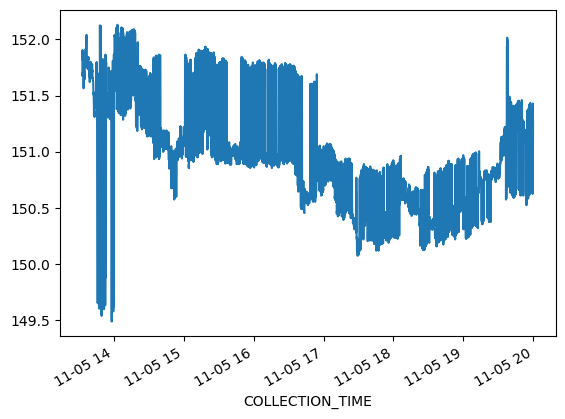

In [117]:
df_data['CLOSE'].plot()

In [118]:
def train_test_split(data, train_terst_ratio = 0.8, stack_size = 3):

    X, y = data[["MACD", "BOP", "RSI", "SOBV"]], data["target"]
    train_length = int(X.shape[0] * train_terst_ratio)

    scaler = MinMaxScaler()
    scaler.fit(X[:train_length])
    X = scaler.transform(X)

    
    new_array = []
    for i in range(0, X.shape[0] - stack_size + 1):
        window = X[i : i + stack_size, :]
        new_array.append(window)
    
    X, y = np.stack(new_array), y[stack_size - 1:].values.reshape(-1, 1)
    
    X_train = torch.tensor(X[:train_length, :], dtype=torch.float32)
    X_test = torch.tensor(X[train_length:, :], dtype=torch.float32)
    y_train = torch.tensor(y[:train_length], dtype=torch.float32)
    y_test = torch.tensor(y[train_length:], dtype=torch.float32)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(df_data)

In [119]:
y_test

tensor([[0.0641],
        [0.6046],
        [0.6046],
        [0.4940],
        [0.3899],
        [0.9409],
        [0.0611],
        [0.9109],
        [0.8579],
        [0.3599],
        [0.0831],
        [0.6597],
        [0.7017],
        [0.9119],
        [0.0831],
        [0.4940],
        [0.9159],
        [0.0921],
        [0.8699],
        [0.0901],
        [0.8579],
        [0.9119],
        [0.0636],
        [0.8619],
        [0.3899],
        [0.1431],
        [0.9399],
        [0.0631],
        [0.3899],
        [0.8634],
        [0.6787],
        [0.8999],
        [0.4940],
        [0.0981],
        [0.9059],
        [0.0984],
        [0.2998],
        [0.2893],
        [0.9119],
        [0.4940],
        [0.0611],
        [0.9023],
        [0.0981],
        [0.4940],
        [0.9023],
        [0.8634],
        [0.1148],
        [0.2818],
        [0.9014],
        [0.1001],
        [0.8899],
        [0.7743],
        [0.0631],
        [0.6046],
        [0.9389],
        [0

In [120]:
X_test.size()

torch.Size([922, 6, 4])

In [121]:
y_test.size()

torch.Size([922, 1])

In [122]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads) -> None:
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_process(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1) / math.sqrt(self.d_k))
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Split into multiheads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_q(K))
        V = self.split_heads(self.W_q(V))

        # do the matrix multiplication
        attn_outputs = self.scaled_dot_process(Q, K, V, mask)
        # combine the multiheads, send into a linear layer and get the output
        out_put = self.W_o(self.combine_heads(attn_outputs))
        # The output has the same shape like the input
        return out_put


class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length) -> None:
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        # Unsqueeze to match with the dimension of the series
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        # print(f"The shape of the input for PositionalEncoding is {x.shape}")
        return x + self.pe[:, : x.size(1)]


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout) -> None:
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


class Transformer(nn.Module):
    def __init__(
        self,
        training_data_size,
        target_data_size,
        d_model,
        num_heads,
        num_layers,
        d_ff,
        dropout,
    ):
        super(Transformer, self).__init__()

        self.encoder_embedding = nn.Linear(training_data_size[2], d_model)
        self.positional_encoding = PositionalEncoding(d_model, training_data_size[1])
        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )
        self.fc = nn.Linear(d_model, target_data_size[1])
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        return src_mask

    def forward(self, src):
        src_embedded = self.dropout(
            self.positional_encoding(self.encoder_embedding(src))
        )
                
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, None)

        # out_put = self.softmax(self.fc(enc_output))
        out_put = self.fc(enc_output)
        return out_put[:, -1, :]


d_model = 128
num_heads = 8
num_layers = 4
d_ff = 256
dropout = 0.1

transformer = Transformer(
    X_train.size(),  # Shape of the input data
    y_train.size(),  # Shape of the output data
    d_model,  # The dimensionality of the token embeddings used in the transformer model.
    num_heads,  # The number of attention heads in each attention layer within the transformer model.
    num_layers,  # The number of encoder and decoder layers in the transformer model.
    d_ff,  # The dimensionality of the feedforward network model in the transformer's encoder and decoder.
    dropout,  # The dropout rate used in the transformer for regularization.
)


In [123]:
y_train

tensor([[0.2227],
        [0.7743],
        [0.7122],
        ...,
        [0.2613],
        [0.1451],
        [0.9428]])

In [124]:
from torch.optim import lr_scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

loss_values = {}

for epoch in tqdm(range(400)):
    transformer.train()
    optimizer.zero_grad()
    outputs = transformer(X_train)

    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()
    # print(outputs, y_train)
        
    with torch.inference_mode():
        test_pred = scaler.inverse_transform(transformer(X_test))
        y_test_original = scaler.inverse_transform(y_test)
        test_loss = criterion(test_pred, y_test_original)
        sign_equal = (torch.sign(test_pred) == torch.sign(y_test_original))
        matching_ratio = torch.sum(sign_equal).item() / test_pred.size(0) 
        print(f"Epoch: {epoch} | MSE Train Loss: {loss.item()} | MSE Test Loss: {test_loss.item()}", matching_ratio)
        

  0%|          | 0/400 [00:00<?, ?it/s]

TypeError: 'int' object is not callable

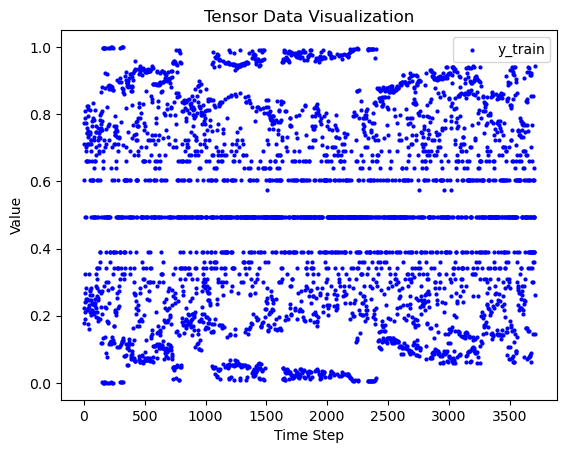

In [110]:
x = torch.arange(len(y_train)).detach().numpy()

tem = y_train.detach().numpy().reshape(-1)
tem2 = outputs.detach().numpy().reshape(-1)

plt.scatter(x, tem, label='y_train', color='blue', s=4)
# plt.scatter(x, tem2, label='outputs', color='red', s=4)

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Tensor Data Visualization')
plt.legend()  # 添加图例
plt.show()



In [126]:
test_pred, y_test_original

(array([[-2.21      ],
        [-2.21      ],
        [-2.21      ],
        [-0.72874866],
        [-0.01      ],
        [-0.80275905],
        [-0.01      ],
        [-0.03      ],
        [-2.21      ],
        [-0.7200917 ],
        [-0.40300346],
        [-2.21      ],
        [ 0.        ],
        [-0.4537267 ],
        [-2.21      ],
        [-0.03154803],
        [-2.21      ],
        [-0.20596586],
        [ 0.        ],
        [-0.81502049],
        [-0.01      ],
        [-2.21      ],
        [-0.64082038],
        [-0.04615591],
        [-0.02      ],
        [-0.07922381],
        [-2.21      ],
        [-0.45      ],
        [-0.50534052],
        [ 0.        ],
        [-0.65286429],
        [-2.21      ],
        [-0.005     ],
        [-0.15480872],
        [-2.21      ],
        [-0.055     ],
        [-2.21      ],
        [-2.21      ],
        [-2.21      ],
        [-0.48      ],
        [-2.21      ],
        [-0.45308231],
        [-2.21      ],
        [-0

In [ ]:
test_pred, y_test

(tensor([[ 2.8828e-01],
         [ 7.1173e-02],
         [-1.4729e-01],
         [ 2.3911e-01],
         [-2.2606e-01],
         [-1.0975e-01],
         [-1.7056e-01],
         [-5.1995e-02],
         [ 1.7656e-02],
         [-2.8820e-01],
         [ 8.9222e-02],
         [-6.6482e-02],
         [ 3.0392e-01],
         [-1.7170e-01],
         [ 1.0412e-02],
         [-4.7162e-01],
         [-3.6782e-01],
         [-2.0278e-02],
         [-1.1781e-01],
         [ 1.2757e-01],
         [ 2.1145e-01],
         [-1.2139e-01],
         [ 2.9957e-01],
         [-1.0813e-02],
         [-4.2203e-02],
         [ 2.1470e-01],
         [-2.0283e-01],
         [ 2.4130e-01],
         [-4.9383e-02],
         [ 1.3223e-01],
         [ 1.7761e-01],
         [-1.2498e-01],
         [-4.0283e-01],
         [-2.7116e-02],
         [-2.1825e-01],
         [-7.1069e-02],
         [-2.8558e-01],
         [-1.0927e-01],
         [ 1.2807e-01],
         [ 1.4654e-01],
         [ 9.5174e-02],
         [ 7.379

In [ ]:
sign_equal = (torch.sign(test_pred) == torch.sign(y_test))

# 计算符号相同的比率
matching_ratio = torch.sum(sign_equal).item() / test_pred.size(0)  # 其中 n 是张量的长度

print("符号相同的比率：", matching_ratio)

符号相同的比率： 0.5891304347826087


In [ ]:
sign_equal = (torch.sign(test_pred) == torch.sign(y_test))

# 计算符号相同的比率
matching_ratio = torch.sum(sign_equal).item() / test_pred.size(0)  # 其中 n 是张量的长度

print("符号相同的比率：", matching_ratio)

符号相同的比率： 0.6130434782608696
